# Measuring calibration factor 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import pymc3 as pm
import scipy.optimize
import tqdm
import theano.tensor as tt
import scipy.io
import sys
sys.path.insert(0, '../../../')
import mwc.process
import mwc.viz
colors = mwc.viz.set_plotting_style()
%matplotlib inline

In [10]:
def clist_to_df(clist_file, desired_props='default', added_props={}, excluded_props=None):
    """
    Reads in a SuperSegger `clist` file and extracts the desired properties.
     
    Parameters
    ----------
    clist_file : str
        Path to clist file of interest.
    desired_props: list of str
        A list of the desired properties. Default selection is ['Area birth', 'Area death', 
        'Cell ID', 'Cell birth time', 'Cell death time', 'Daughter1 ID', 'Daughter2 ID',
        'Fluor1 mean death', 'Fluor2 mean death', 'Mother ID']
    added_props : dict
        A dict of additional props to include in the DataFrame.
    excluded_props : list or tuple of str
        Properties from the default included properties to ignore. These should match 
        the case exactly as defined in the SuperSegger documentation.
    
    Returns
    -------
    df : pandas DataFrame
        A tidy pandas DataFrame with extracted properties for all cells in the clist file.
    """
    # Ensure that the clist file is a string. 
    if type(clist_file) is not str:
        raise TypeError('clist_file must be a string')
   
    # Convert the excluded props to a list if is given as a string.
    if type(excluded_props) == str:
        excluded_props = list(excluded_props)
        
    # Load the clist file using scipy.
    mat = scipy.io.loadmat(clist_file, squeeze_me=True)
    
    # Assemble a dictionary of the indices and key values. 
    if desired_props == 'default':
        desired_props = ['Area birth', 'Area death', 'Cell ID', 'Cell birth time', 
                         'Cell death time', 'Daughter1 ID', 'Daughter2 ID',
                         'Fluor1 mean death', 'Fluor2 mean death', 'Mother ID']
    defs = {key: value for value, key in enumerate(mat['def']) if key in desired_props}
    
    # Generate an empty DataFrame with the desired columns.
    for k, v in added_props.items():
        desired_props.append(k)     
    df = pd.DataFrame([], columns=desired_props)
    
    # Iterate through the clist and extrac the properties.
    for i, cell in enumerate(mat['data']):  
        # Extract the properties and add to DataFrame
        cell_dict = {}
        try:
            for key, value in defs.items():
                cell_dict[key] = cell[value]
#             cell_dict = {key: cell[value] for key, value in defs.items()}
        except:
            print(key, value)
        
        # Add any additional properties. 
        for k, v in added_props.items():
            cell_dict[k] = v
        df = df.append(cell_dict, ignore_index=True)
         
    # Rename the columns to accomodate pep8 style.
    if excluded_props is not None:
            for x in excluded_props:
                df.drop(x, axis=1, inplace=True)
    new_cols = {nom: '_'.join(nom.split(' ')).lower() for nom in df.keys()}
    df.rename(columns=new_cols, inplace=True)
    return df
        

def parse_clists(clists, parse_position=True, added_props={}, 
                 verbose=False, **kwargs):
    """
    A helper function to iterate over a list of clist files. See `clist_to_df` for function
    documentation
    
    Parameters
    ----------
    clists: list of str
        A list of pathnames for clist files.
    parse_position: bool
        If True, the position of the item will be parsed from the file name by splitting at 
        'xy'.
    added_props: dict
        A dictionary of additional props to add to the DataFrame. Default is an empty dict.
        If `parse_psotion` is True, the position will be passed as an added property.
    verbose: bool
        If True, a progressbar will be displayed for the clist iteration.
    
    Returns
    -------
    df : pandas DataFrame
        A pandas DataFrame containing all cell properties for each item in the provided 
        clist file.
    
    """
 
    # Iterate through each item in the clists.
    dfs = []
    if verbose:
        iterator = tqdm.tqdm(clists)
    else:
        iterator = clists
    for i, c in enumerate(iterator):
        # Parse the position.
        pos = int(c.split('xy')[-1].split('/')[0])        
        print(pos)
        if parse_position:
            added_props['position'] = pos
        
        # Pass the file to the parser.
        df = clist_to_df(c, added_props=added_props, **kwargs)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True) 

In [11]:
# Define the data directory
data_dir = '../../../data/images/20180205_37C_glucose_O2_dilution/'

# Find all of the growth clist files. 
growth = glob.glob('{0}/*growth*/xy*/clist.mat'.format(data_dir))

# Parse the growth clist files.
growth_df = mwc.process.parse_clists(growth, excluded_props=['Fluor2 mean death'])

# Parse the snapshots.
snaps = glob.glob('{0}/*snaps*/'.format(data_dir))
dfs = []
for i, s in enumerate(snaps):
    # Find the strain. 
    strain, atc  = s.split('/')[-2].split('_')[-3:-1]
    atc_conc = float(atc.split('ngmL')[0])
    add_props = {'strain':strain, 'atc_conc':atc_conc}
 
    # Parse the clist files.
    clists = glob.glob('{0}/xy*/clist.mat'.format(s))
    _df = mwc.process.parse_clists(clists, added_props=add_props, excluded_props=['Cell ID'])       
    dfs.append(_df)
snap_df = pd.concat(dfs, ignore_index=True)

In [12]:
# Compute the autofluorescence values.
auto_strain = snap_df[snap_df['strain']=='autofluorescence']
mean_auto_cherry = auto_strain['fluor1_mean_death'].mean()
mean_auto_yfp = auto_strain['fluor2_mean_death'].mean()

In [13]:
# Extract the measured sisters. 
measured = growth_df[growth_df['fluor1_mean_death'] > 0]
grouped = measured.groupby(['position', 'mother_id']) 
cal_df = pd.DataFrame([], columns=['I_1', 'I_2', 'summed', 'fluctuation'])
for g, d in grouped:
    if len(d) == 2:
        sisters  = (d['fluor1_mean_death'].values - mean_auto_cherry) * d['area_death'].values
        if (sisters >= 0).all():
            cell_dict = {'I_1':sisters[0], 'I_2':sisters[1], 
                        'summed':sisters.sum(), 'fluctuation':np.diff(sisters)**2}
            cal_df = cal_df.append(cell_dict, ignore_index=True)

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


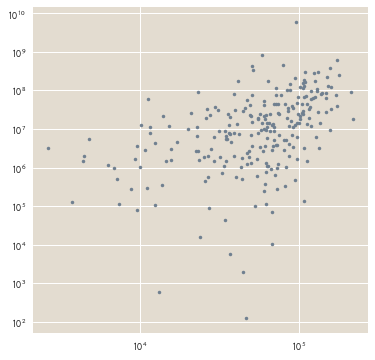

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.loglog(cal_df['summed'], cal_df['fluctuation'], '.', color='slategray')

In [16]:
with pm.Model() as model:
    alpha = DeterministicLogPosterior('alpha', testval=100)
    trace = pm.sample(draws=10000, tune=10000)
    trace_df = pboc.mcmc.trace_to_dataframe(trace, model)
    stats = pboc.mcmc.compute_statistics(trace_df) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 20000/20000 [00:17<00:00, 1151.35it/s]


NameError: name 'pboc' is not defined

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92b927f9b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f92b9257a20>]], dtype=object)

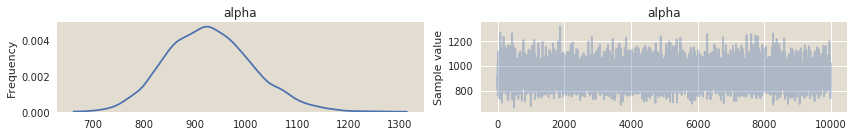

In [17]:
pm.traceplot(trace)

In [19]:
# Subtract the autofluorescence.
snap_df['fluor1_sub'] = snap_df['area_death'] * (snap_df['fluor1_mean_death'] - mean_auto_cherry)
snap_df['fluor2_sub'] = snap_df['area_death'] * (snap_df['fluor2_mean_death'] - mean_auto_yfp)

# Compute the mean constitutive expression.
mean_delta = snap_df[snap_df['strain'] == 'deltaLacI']['fluor2_sub'].mean()

# Group the dilution data by the aTc concentration.
grouped = snap_df[snap_df['strain']=='dilution'].groupby('atc_conc')

# Set up lsits to store the repressor copy number and the fold change. 
mean_repressors = []
repressor_extrema = []
fold_change = []

for g, d in grouped:
    # Compute the fold-change.
    fold_change.append(d['fluor2_sub'].values.mean() / mean_delta)
    
    # Compute the repressor copy number.
    mean_repressors.append((d['fluor1_sub'].values.mean() / 950))
#     max_rep = d['fluor1_sub'].values.mean() / stats['hpd_max'].values
#     min_rep = d['fluor1_sub'].values.mean() / stats['hpd_min'].values
#     repressor_extrema.append((min_rep[0], max_rep[0])) 

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


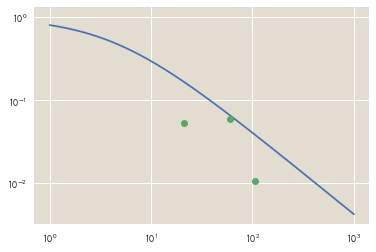

In [22]:
# Compute the theoretical fold-change.
ep_R = -13.9
N_ns = 4.6E6
R_range = np.logspace(0, 3, 500)
theo = (1 + (R_range / N_ns) * np.exp(-ep_R))**-1

# Set up the plotting canvas.
fig, ax = plt.subplots()
ax.loglog(R_range, theo)
ax.loglog(mean_repressors, fold_change, 'o')
